In [2]:
from pyspark.sql import SparkSession

# Création d'une session Spark locale (multi-core)
spark = SparkSession.builder \
    .appName("Enedis_EDA_BigData") \
    .master("local[*]") \
    .getOrCreate()

spark

In [3]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
df = spark.read.parquet("/content/drive/MyDrive/Projet_bigData/Data/consommation.parquet")

# Afficher le schéma structuré
df.printSchema()


root
 |-- operateur: string (nullable = true)
 |-- filiere: string (nullable = true)
 |-- annee: date (nullable = true)
 |-- code_commune: string (nullable = true)
 |-- nom_commune: string (nullable = true)
 |-- code_epci: string (nullable = true)
 |-- nom_epci: string (nullable = true)
 |-- type_epci: string (nullable = true)
 |-- code_departement: string (nullable = true)
 |-- nom_departement: string (nullable = true)
 |-- code_region: string (nullable = true)
 |-- nom_region: string (nullable = true)
 |-- code_categorie_consommation: string (nullable = true)
 |-- code_grand_secteur: string (nullable = true)
 |-- code_secteur_naf2: string (nullable = true)
 |-- nb_sites: long (nullable = true)
 |-- conso_totale_mwh: double (nullable = true)
 |-- conso_moyenne_mwh: double (nullable = true)
 |-- nombre_de_mailles_secretisees: double (nullable = true)
 |-- part_thermosensible: double (nullable = true)
 |-- conso_totale_a_usages_thermosensibles_mwh: double (nullable = true)
 |-- conso_to

In [7]:
# Aperçu des premières lignes
df.show(10, truncate=False)

# Nombre total de lignes
df.count()

+---------+-----------+----------+------------+-------------+---------+-----------------------------------------------------------------------------------+---------+----------------+---------------+-----------+----------+---------------------------+------------------+-----------------+--------+----------------+-----------------+-----------------------------+-------------------+-----------------------------------------+---------------------------------------------+--------------------------------+-----------------------------------------------------------------------+------------------------------------------+----------------------------------------------+---------------------------------+------------------------------------------------------------------------+------------------+------------------+------------------+----------------------------+------------------------------+------------------------------+-----------------------------------+-----------------------------------+----------

3405751

# Détection automatique des colonnes numériques vs catégorielles

In [8]:
from pyspark.sql.types import *

numeric_types = [IntegerType, LongType, FloatType, DoubleType, ShortType, DecimalType]

numeric_cols = [c for c, t in df.dtypes if t in ["int", "bigint", "double", "float"]]
categorical_cols = [c for c, t in df.dtypes if t == "string"]

numeric_cols, categorical_cols


(['nb_sites',
  'conso_totale_mwh',
  'conso_moyenne_mwh',
  'nombre_de_mailles_secretisees',
  'part_thermosensible',
  'conso_totale_a_usages_thermosensibles_mwh',
  'conso_totale_a_usages_non_thermosensibles_mwh',
  'thermosensibilite_totale_kwh_dju',
  'conso_totale_corrigee_de_l_alea_climatique_a_usages_thermosensibles_mwh',
  'conso_moyenne_a_usages_thermosensibles_mwh',
  'conso_moyenne_a_usages_non_thermosensibles_mwh',
  'thermosensibilite_moyenne_kwh_dju',
  'conso_moyenne_corrigee_de_l_alea_climatique_a_usages_thermosensibles_mwh',
  'dju_a_tr',
  'dju_a_tn',
  'nombre_d_habitants',
  'taux_de_logements_collectifs',
  'taux_de_residences_principales',
  'superficie_des_logements_30_m2',
  'superficie_des_logements_30_a_40_m2',
  'superficie_des_logements_40_a_60_m2',
  'superficie_des_logements_60_a_80_m2',
  'superficie_des_logements_80_a_100_m2',
  'superficie_des_logements_100_m2',
  'residences_principales_avant_1919',
  'residences_principales_de_1919_a_1945',
  'reside

# Analyse des valeurs manquantes (manquant / total / %)

  Retourne un DataFrame Spark avec :
  
    - colonne

    - nb_valeurs_manquantes

    - proportion_manquante (%)

In [9]:
from pyspark.sql.functions import col, sum as spark_sum, count, round

def missing_values_report(df):
    """

    """

    total_rows = df.count()

    # Calcul du nombre de valeurs manquantes par colonne
    missing_df = df.select([
        spark_sum(col(c).isNull().cast("int")).alias(c)
        for c in df.columns
    ])

    # Conversion en un format long (colonne / nb manquants)
    missing_long = missing_df.toPandas().T.reset_index()
    missing_long.columns = ["colonne", "nb_manquants"]

    # Passage en DataFrame Spark pour continuer les traitements
    missing_spark = spark.createDataFrame(missing_long)

    # Ajout du pourcentage
    missing_spark = missing_spark.withColumn(
        "proportion (%)",
        round(col("nb_manquants") / total_rows * 100, 2)
    )

    # Ordre décroissant : les colonnes les plus problématiques en bas
    return missing_spark.orderBy(col("proportion (%)").asc())


# Lancer l’analyse
missing_report = missing_values_report(df)
missing_report.show(50,truncate=False)


+------------------------------------------------------------------------+------------+--------------+
|colonne                                                                 |nb_manquants|proportion (%)|
+------------------------------------------------------------------------+------------+--------------+
|operateur                                                               |0           |0.0           |
|filiere                                                                 |0           |0.0           |
|annee                                                                   |0           |0.0           |
|code_commune                                                            |0           |0.0           |
|nom_commune                                                             |54          |0.0           |
|code_epci                                                               |54          |0.0           |
|nom_epci                                                                

# Suppression des colonnes avec plus de 98% de valeurs manquantes

In [10]:
# 2. Extraction des colonnes à supprimer
missing_pd = missing_report.toPandas()
cols_to_drop = missing_pd[missing_pd["proportion (%)"] > 98]["colonne"].tolist()
cols_to_drop.extend(["code_commune","code_epci","type_epci"])
print("Colonnes à supprimer:")
print(cols_to_drop)

# 3. Suppression des colonnes
df = df.drop(*cols_to_drop)

# 4. Vérification
print("Schéma après nettoyage :")
df.printSchema()

Colonnes à supprimer:
['code_commune', 'code_epci', 'type_epci']
Schéma après nettoyage :
root
 |-- operateur: string (nullable = true)
 |-- filiere: string (nullable = true)
 |-- annee: date (nullable = true)
 |-- nom_commune: string (nullable = true)
 |-- nom_epci: string (nullable = true)
 |-- code_departement: string (nullable = true)
 |-- nom_departement: string (nullable = true)
 |-- code_region: string (nullable = true)
 |-- nom_region: string (nullable = true)
 |-- code_categorie_consommation: string (nullable = true)
 |-- code_grand_secteur: string (nullable = true)
 |-- code_secteur_naf2: string (nullable = true)
 |-- nb_sites: long (nullable = true)
 |-- conso_totale_mwh: double (nullable = true)
 |-- conso_moyenne_mwh: double (nullable = true)
 |-- nombre_de_mailles_secretisees: double (nullable = true)
 |-- part_thermosensible: double (nullable = true)
 |-- conso_totale_a_usages_thermosensibles_mwh: double (nullable = true)
 |-- conso_totale_a_usages_non_thermosensibles_mw

# Calcul des moyennes pour les colonnes numériques

In [11]:
numeric_cols = [c for c, t in df.dtypes if t in ["int", "bigint", "double", "float"]]
categorical_cols = [c for c, t in df.dtypes if t == "string"]

numeric_cols, categorical_cols

(['nb_sites',
  'conso_totale_mwh',
  'conso_moyenne_mwh',
  'nombre_de_mailles_secretisees',
  'part_thermosensible',
  'conso_totale_a_usages_thermosensibles_mwh',
  'conso_totale_a_usages_non_thermosensibles_mwh',
  'thermosensibilite_totale_kwh_dju',
  'conso_totale_corrigee_de_l_alea_climatique_a_usages_thermosensibles_mwh',
  'conso_moyenne_a_usages_thermosensibles_mwh',
  'conso_moyenne_a_usages_non_thermosensibles_mwh',
  'thermosensibilite_moyenne_kwh_dju',
  'conso_moyenne_corrigee_de_l_alea_climatique_a_usages_thermosensibles_mwh',
  'dju_a_tr',
  'dju_a_tn',
  'nombre_d_habitants',
  'taux_de_logements_collectifs',
  'taux_de_residences_principales',
  'superficie_des_logements_30_m2',
  'superficie_des_logements_30_a_40_m2',
  'superficie_des_logements_40_a_60_m2',
  'superficie_des_logements_60_a_80_m2',
  'superficie_des_logements_80_a_100_m2',
  'superficie_des_logements_100_m2',
  'residences_principales_avant_1919',
  'residences_principales_de_1919_a_1945',
  'reside

In [12]:
from pyspark.sql.functions import mean

means = df.select([mean(c).alias(c) for c in numeric_cols]).collect()[0].asDict()
means


{'nb_sites': 238.32856500333148,
 'conso_totale_mwh': 4076.238770192734,
 'conso_moyenne_mwh': 924.7843279610909,
 'nombre_de_mailles_secretisees': 0.11261950741554506,
 'part_thermosensible': 2.9120318313068956,
 'conso_totale_a_usages_thermosensibles_mwh': 1835.0983811857825,
 'conso_totale_a_usages_non_thermosensibles_mwh': 6441.456976812069,
 'thermosensibilite_totale_kwh_dju': 156.58225599660815,
 'conso_totale_corrigee_de_l_alea_climatique_a_usages_thermosensibles_mwh': 1961.4305175841178,
 'conso_moyenne_a_usages_thermosensibles_mwh': 1.2863701008452024,
 'conso_moyenne_a_usages_non_thermosensibles_mwh': 8.904289740516802,
 'thermosensibilite_moyenne_kwh_dju': 0.10411545484076717,
 'conso_moyenne_corrigee_de_l_alea_climatique_a_usages_thermosensibles_mwh': 1.3776117831591497,
 'dju_a_tr': 1609.8653009178263,
 'dju_a_tn': 1716.4288053485564,
 'nombre_d_habitants': 7188.557847407707,
 'taux_de_logements_collectifs': 16.78438225204657,
 'taux_de_residences_principales': 69.61843773

# Calcul automatique du mode pour chaque colonne catégorielle

In [13]:
from pyspark.sql.functions import col, desc

modes = {}

for c in categorical_cols:
    mode_value = df.groupBy(c).count().orderBy(desc("count")).first()[0]
    modes[c] = mode_value

modes


{'operateur': 'Enedis',
 'filiere': 'Electricité',
 'nom_commune': 'Saint-Marcel',
 'nom_epci': 'Métropole du Grand Paris',
 'code_departement': '59',
 'nom_departement': 'Nord',
 'code_region': '84',
 'nom_region': 'Auvergne-Rhône-Alpes',
 'code_categorie_consommation': 'ENT',
 'code_grand_secteur': 'TERTIAIRE',
 'code_secteur_naf2': None,
 'residences_principales_de_2006_a_2018': None,
 'residences_principales_apres_2019': None}

#Remplacement global des valeurs manquantes

In [14]:
df = df.fillna(means, subset=numeric_cols)

# traiter les colonnes dont le mode est valide
valid_modes = {k: v for k, v in modes.items() if v is not None}
df = df.fillna(valid_modes)


In [15]:
# Sauvegarde en Parquet (overwrite = remplace si existe déjà)
df.write.mode("overwrite").parquet("/content/drive/MyDrive/Projet_bigData/Data/consommation_clean.parquet")

# STATISTIQUES DESCRIPTIVES GLOBALES

In [16]:

df.describe().show(truncate=False)


+-------+----------------+-----------+------------------------------+----------------------------+------------------+---------------+-----------------+--------------------+---------------------------+------------------+------------------+------------------+------------------+------------------+-----------------------------+-------------------+-----------------------------------------+---------------------------------------------+--------------------------------+-----------------------------------------------------------------------+------------------------------------------+----------------------------------------------+---------------------------------+------------------------------------------------------------------------+------------------+-----------------+------------------+----------------------------+------------------------------+------------------------------+-----------------------------------+-----------------------------------+-----------------------------------+----------

# COMPTAGE DES VALEURS MANQUANTES PAR COLONNE

In [17]:

from pyspark.sql.functions import col, sum

null_counts = df.select([
    sum(col(c).isNull().cast("int")).alias(c)
    for c in df.columns
])

null_counts.show(truncate=False)


+---------+-------+-----+-----------+--------+----------------+---------------+-----------+----------+---------------------------+------------------+-----------------+--------+----------------+-----------------+-----------------------------+-------------------+-----------------------------------------+---------------------------------------------+--------------------------------+-----------------------------------------------------------------------+------------------------------------------+----------------------------------------------+---------------------------------+------------------------------------------------------------------------+--------+--------+------------------+----------------------------+------------------------------+------------------------------+-----------------------------------+-----------------------------------+-----------------------------------+------------------------------------+-------------------------------+---------------------------------+----------

# CONSOMMATION TOTALE PAR ANNÉE

In [18]:
from pyspark.sql.functions import year, sum

df.groupBy(year("annee").alias("annee")) \
  .agg(sum("conso_totale_mwh").alias("conso_totale_mwh")) \
  .orderBy("annee") \
  .show(20, truncate=False)


+-----+--------------------+
|annee|conso_totale_mwh    |
+-----+--------------------+
|2011 |8.108887427819794E8 |
|2012 |9.086154917863779E8 |
|2013 |9.340652856997628E8 |
|2014 |8.423791964194523E8 |
|2015 |8.984015451845737E8 |
|2016 |9.484904253507805E8 |
|2017 |9.428086954959197E8 |
|2018 |1.1259593772178302E9|
|2019 |1.1311400592371297E9|
|2020 |1.0916703837804315E9|
|2021 |1.1415529509487448E9|
|2022 |1.0849941896828165E9|
|2023 |1.0176237315285904E9|
|2024 |1.0040641927103721E9|
+-----+--------------------+



# CONSOMMATION PAR secteur

In [19]:
from pyspark.sql.functions import sum

df.groupBy("code_grand_secteur") \
  .agg(sum("conso_totale_mwh").alias("conso_totale_mwh")) \
  .orderBy("conso_totale_mwh", ascending=False) \
  .show(truncate=False)


+------------------+--------------------+
|code_grand_secteur|conso_totale_mwh    |
+------------------+--------------------+
|INDUSTRIE         |5.132623908665805E9 |
|RESIDENTIEL       |4.628443110097546E9 |
|TERTIAIRE         |2.9340601363714805E9|
|INCONNU           |6.042816476933162E8 |
|AGRICULTURE       |5.811413784358226E8 |
|NAP               |2104086.558766513   |
+------------------+--------------------+



<Axes: xlabel='code_grand_secteur'>

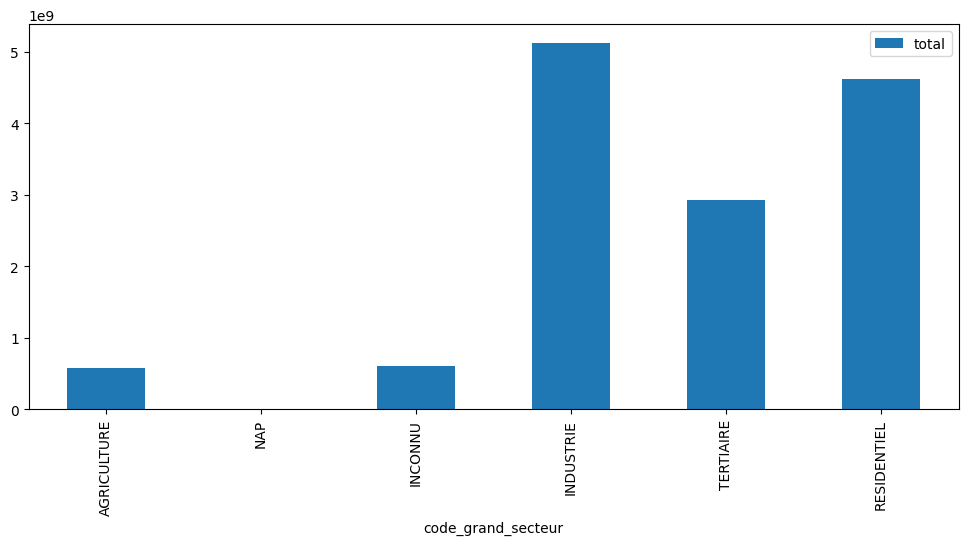

In [20]:
pdf = df.groupBy("code_grand_secteur") \
        .agg(sum("conso_totale_mwh").alias("total")) \
        .toPandas()

pdf.plot(kind="bar", x="code_grand_secteur", y="total", figsize=(12,5))


# CONSOMMATION PAR catégorie de consommation

In [21]:


df.groupBy("code_categorie_consommation") \
  .agg(sum("conso_totale_mwh").alias("conso_totale_mwh")) \
  .orderBy("conso_totale_mwh", ascending=False) \
  .show(truncate=False)


+---------------------------+--------------------+
|code_categorie_consommation|conso_totale_mwh    |
+---------------------------+--------------------+
|ENT                        |7.189305641564625E9 |
|RES                        |4.628443110097546E9 |
|PRO                        |2.0101193535267382E9|
|ENT_PRO                    |5.478616264287207E7 |
+---------------------------+--------------------+



# CONSOMMATION PAR Département

In [22]:
df.groupBy("nom_departement") \
  .agg(sum("conso_totale_mwh").alias("conso_totale_mwh")) \
  .orderBy("conso_totale_mwh", ascending=False) \
  .show(truncate=False)


+------------------+--------------------+
|nom_departement   |conso_totale_mwh    |
+------------------+--------------------+
|Nord              |8.038736957827384E8 |
|Bouches-du-Rhône  |6.291182816591928E8 |
|Seine-Maritime    |6.264540865899155E8 |
|Pas-de-Calais     |3.760620766542771E8 |
|Moselle           |3.546229460657233E8 |
|Rhône             |3.401556198098216E8 |
|Paris             |3.2514541336473393E8|
|Seine-et-Marne    |3.103682505445256E8 |
|Haut-Rhin         |2.81548986393721E8  |
|Isère             |2.7914415606273735E8|
|Loire-Atlantique  |2.757181629285356E8 |
|Meurthe-et-Moselle|2.6388516627859756E8|
|Yvelines          |2.532736978350532E8 |
|Bas-Rhin          |2.5013394405666244E8|
|Hauts-de-Seine    |2.4529349083400846E8|
|Gironde           |2.430196801007679E8 |
|Seine-Saint-Denis |2.3678442395400655E8|
|Val-de-Marne      |2.1219642171495813E8|
|Haute-Garonne     |2.1102286307575485E8|
|Essonne           |2.0980649262851822E8|
+------------------+--------------

# Par région

In [23]:
df.groupBy("nom_region") \
  .agg(sum("conso_totale_mwh").alias("conso_totale_mwh")) \
  .orderBy("conso_totale_mwh", ascending=False) \
  .show(truncate=False)


+--------------------------+--------------------+
|nom_region                |conso_totale_mwh    |
+--------------------------+--------------------+
|Île-de-France             |1.9677455250507536E9|
|Grand Est                 |1.7462205113640387E9|
|Hauts-de-France           |1.7227585998033662E9|
|Auvergne-Rhône-Alpes      |1.6869985449399137E9|
|Nouvelle-Aquitaine        |1.0894226891528904E9|
|Normandie                 |1.0543088074869968E9|
|Provence-Alpes-Côte d'Azur|1.0513418729430889E9|
|Occitanie                 |9.824190102293763E8 |
|Bourgogne-Franche-Comté   |7.094395122840859E8 |
|Pays de la Loire          |6.783074976895144E8 |
|Bretagne                  |5.552143480001341E8 |
|Centre-Val de Loire       |5.2597451053686655E8|
|Corse                     |4.098106405041071E7 |
|La Réunion                |2.7976315555317387E7|
|Guadeloupe                |1.5702128180821206E7|
|Martinique                |1.5086552830355827E7|
|Guyane                    |8987849.387404863   |


## TOP 20 COMMUNES PAR CONSOMMATION TOTALE

In [24]:

df.groupBy("nom_commune") \
  .agg(sum("conso_totale_mwh").alias("conso_totale_mwh")) \
  .orderBy("conso_totale_mwh", ascending=False) \
  .show(20, truncate=False)


+-------------------------+--------------------+
|nom_commune              |conso_totale_mwh    |
+-------------------------+--------------------+
|Gonfreville-l'Orcher     |2.0228626728388894E8|
|Martigues                |1.820400779334842E8 |
|Paris                    |1.5501634804719365E8|
|Fos-sur-Mer              |1.4316721192901823E8|
|Saint-Avold              |9.522040796673585E7 |
|Port-Jérôme-sur-Seine    |7.445189047887641E7 |
|Dunkerque                |7.066746985155132E7 |
|Toulouse                 |7.051562746332768E7 |
|Bantzenheim              |6.169891186876105E7 |
|Gravelines               |6.1238307004320614E7|
|Montoir-de-Bretagne      |5.819350637368642E7 |
|Strasbourg               |5.4929893640371725E7|
|Marseille                |4.784265876021375E7 |
|Le Grand-Quevilly        |4.468083662499955E7 |
|Lille                    |4.3194864839298174E7|
|Blénod-lès-Pont-à-Mousson|4.312878939795307E7 |
|Merville                 |4.266590325424123E7 |
|Nice               

In [25]:
from pyspark.sql.functions import sum as spark_sum, col as spark_col
import matplotlib.pyplot as plt
import seaborn as sns


# Consommation totale par grand secteur

/tmp/ipython-input-2831317814.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


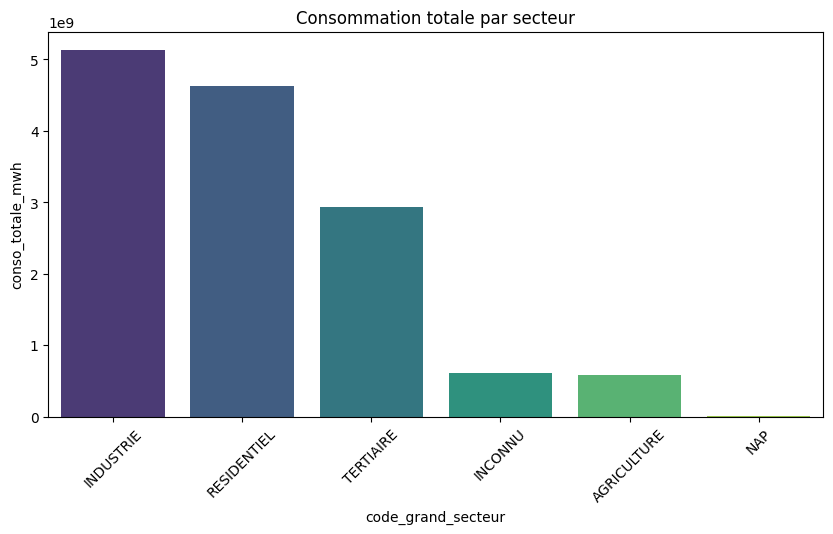

In [27]:


# Agrégation Spark
df_sector = (
    df.groupBy("code_grand_secteur")
      .agg(spark_sum("conso_totale_mwh").alias("conso_totale_mwh"))
      .orderBy("conso_totale_mwh", ascending=False)
)

# Conversion Pandas
pdf_sector = df_sector.toPandas()

# Visualisation

plt.figure(figsize=(10,5))
sns.barplot(
    data=pdf_sector,
    x="code_grand_secteur",
    y="conso_totale_mwh",
    palette="viridis"
)
plt.xticks(rotation=45)
plt.title("Consommation totale par secteur")
plt.show()


# Proportion des secteurs (camembert)

Objectif

Représenter la part de chaque secteur dans la consommation nationale.

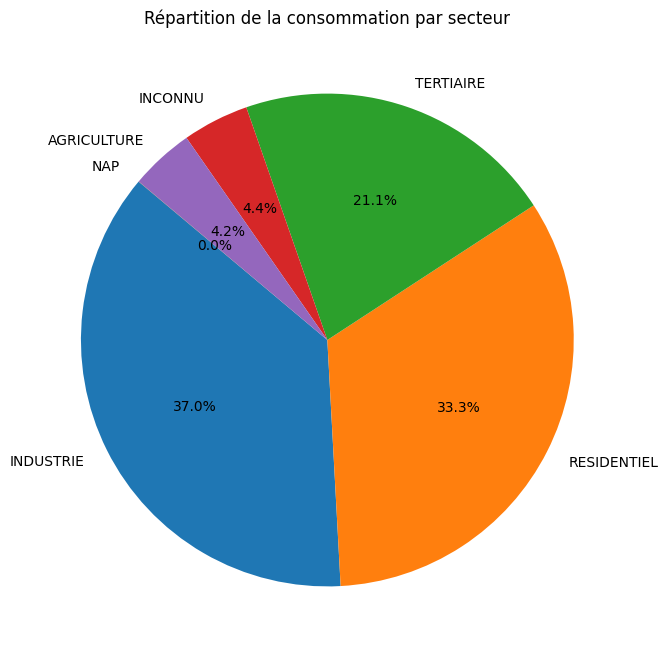

In [28]:
plt.figure(figsize=(8,8))
plt.pie(
    pdf_sector["conso_totale_mwh"],
    labels=pdf_sector["code_grand_secteur"],
    autopct="%1.1f%%",
    startangle=140
)
plt.title("Répartition de la consommation par secteur")
plt.show()


# Consommation moyenne par site (secteur)

🔷 Objectif

Voir quel secteur consomme le plus par site, utile pour détecter :

secteurs énergivores site par site

anomalies industrielles

potentiel de réduction

conso moyenne par site = conso totale / nombre de sites

Exemple :

| Secteur   | Conso totale | Nb sites | Conso/site  |
| --------- | ------------ | -------- | ----------- |
| INDUSTRIE | 400 000 MWh  | 1 000    | **400 MWh** |
| TERTIAIRE | 300 000 MWh  | 10 000   | **30 MWh**  |



/tmp/ipython-input-3505407474.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


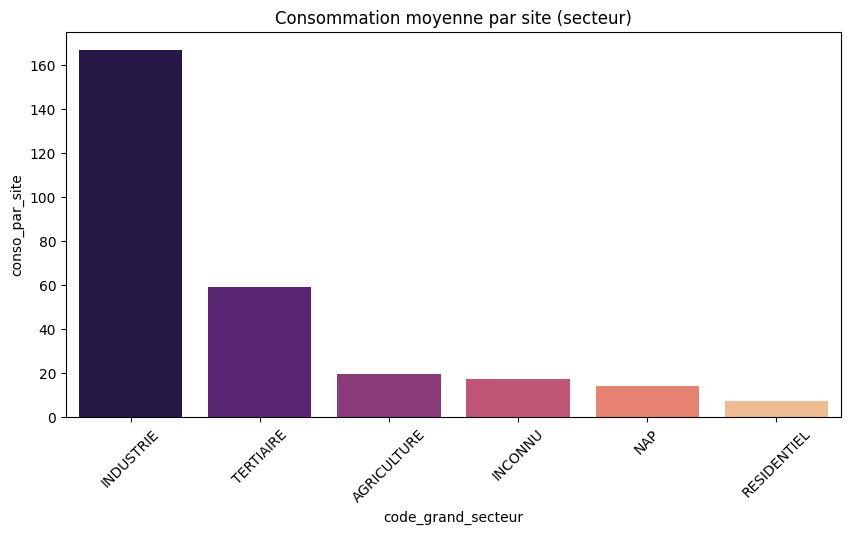

In [29]:
from pyspark.sql.functions import col

df_site_avg = (
    df.groupBy("code_grand_secteur")
      .agg(
          spark_sum("conso_totale_mwh").alias("conso_totale"),
          spark_sum("nb_sites").alias("nb_sites")
      )
      .withColumn("conso_par_site",
                  spark_col("conso_totale") / spark_col("nb_sites"))
      .orderBy("conso_par_site", ascending=False)
)

pdf_site_avg = df_site_avg.toPandas()

plt.figure(figsize=(10,5))
sns.barplot(
    data=pdf_site_avg,
    x="code_grand_secteur",
    y="conso_par_site",
    palette="magma"
)
plt.xticks(rotation=45)
plt.title("Consommation moyenne par site (secteur)")
plt.show()


#Distribution de consommation par secteur

🔷 Objectif

Observer la dispersion (boxplot) :
☑ secteurs très dispersés = comportements hétérogènes
☑ secteurs resserrés = homogènes

/tmp/ipython-input-819645644.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


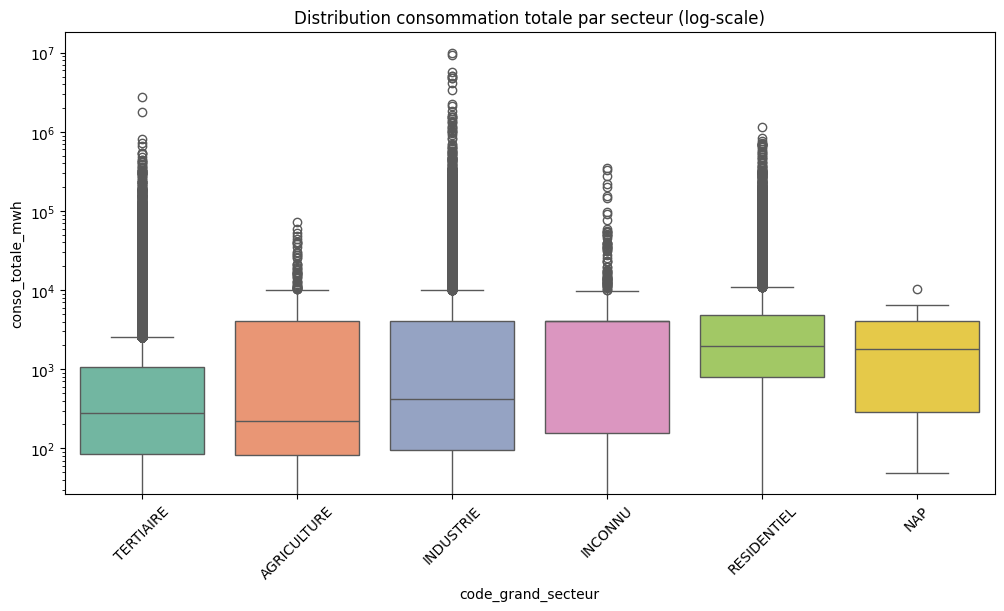

In [30]:
pdf_sample = df.select(
    "code_grand_secteur",
    "conso_totale_mwh"
).sample(False, 0.05, seed=42).toPandas()

plt.figure(figsize=(12,6))
sns.boxplot(
    data=pdf_sample,
    x="code_grand_secteur",
    y="conso_totale_mwh",
    palette="Set2"
)
plt.yscale("log")  # très utile pour les valeurs extrêmes
plt.xticks(rotation=45)
plt.title("Distribution consommation totale par secteur (log-scale)")
plt.show()


#Top 10 sous-secteurs NAF les plus consommateurs

/tmp/ipython-input-2272075508.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


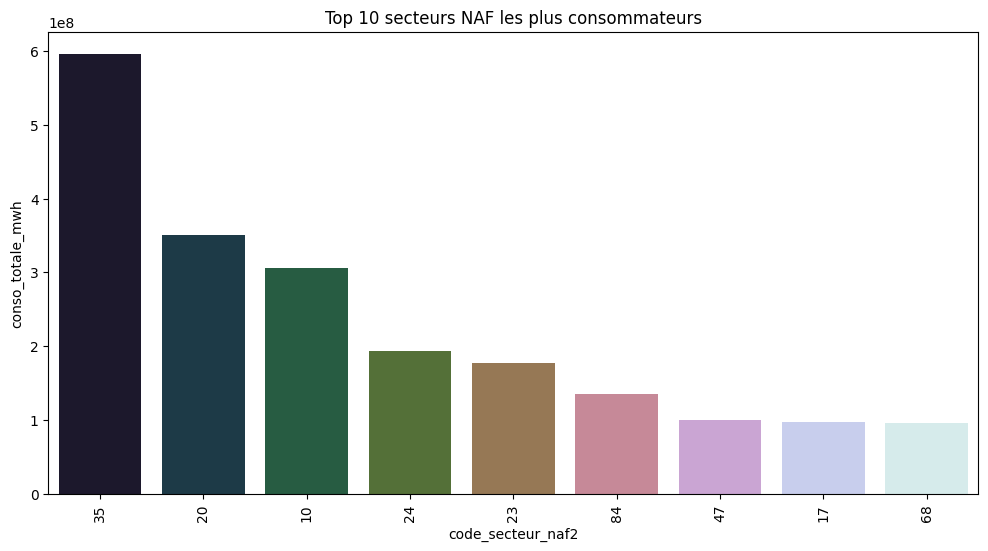

In [31]:
df_naf = (
    df.groupBy("code_secteur_naf2")
      .agg(spark_sum("conso_totale_mwh").alias("conso_totale_mwh"))
      .orderBy("conso_totale_mwh", ascending=False)
      .limit(10)
)

pdf_naf = df_naf.toPandas()

plt.figure(figsize=(12,6))
sns.barplot(
    data=pdf_naf,
    x="code_secteur_naf2",
    y="conso_totale_mwh",
    palette="cubehelix"
)
plt.xticks(rotation=90)
plt.title("Top 10 secteurs NAF les plus consommateurs")
plt.show()


# Top communes les plus consommatrices

/tmp/ipython-input-2461062749.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


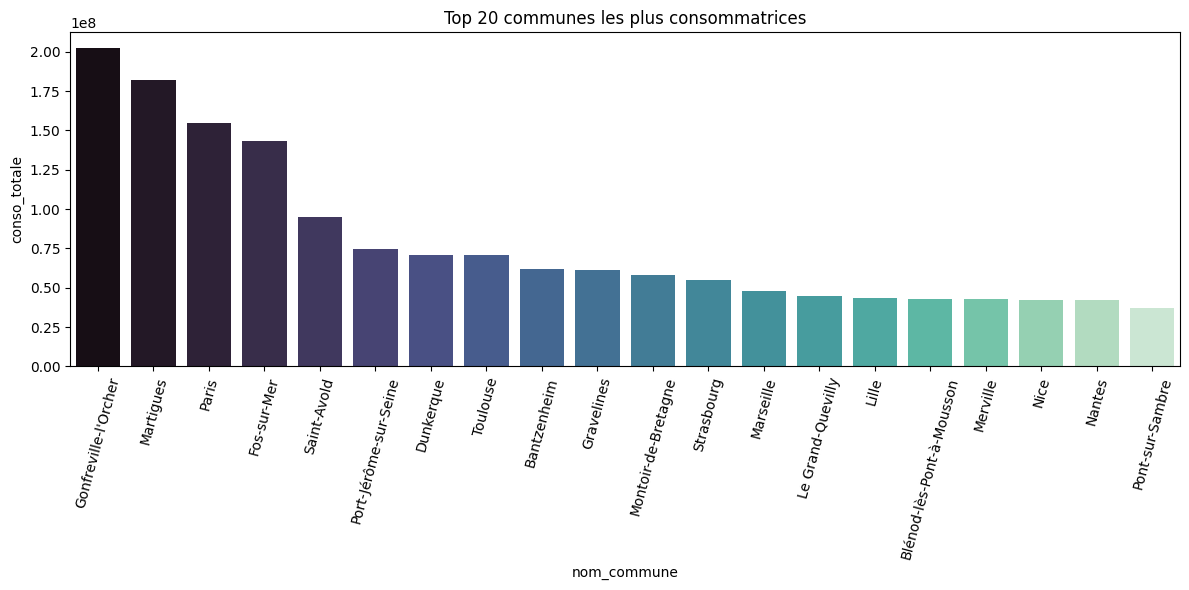

In [32]:
df_communes = (
    df.groupBy("nom_commune")
      .agg(spark_sum("conso_totale_mwh").alias("conso_totale"))
      .orderBy("conso_totale", ascending=False)
)

pdf_communes = df_communes.toPandas()

plt.figure(figsize=(12,6))
sns.barplot(
    data=pdf_communes.head(20),
    x="nom_commune",
    y="conso_totale",
    palette="mako"
)
plt.xticks(rotation=75)
plt.title("Top 20 communes les plus consommatrices")
plt.tight_layout()
plt.show()


# Distribution de la consommation des communes

⚠️ **REMARQUE IMPORTANTE**

Il peut y avoir des doublons de noms de communes (ex : Saint-Denis)
→ d’où l’intérêt d’utiliser code_commune pour les analyses avancées.

Objectif : voir la forme de la distribution → skew, outliers, etc.

In [ ]:
plt.figure(figsize=(10,5))
sns.histplot(
    df.select("conso_totale_mwh").toPandas(),
    x="conso_totale_mwh",
    bins=100,
    kde=True,
)
plt.title("Distribution de la consommation des communes")
plt.show()


**Utiliser une echelle logarithmique pour corriger**

In [ ]:
plt.figure(figsize=(10,5))
sns.histplot(
    df.select("conso_totale_mwh").toPandas(),
    x="conso_totale_mwh",
    bins=100,
    kde=True,
    log_scale=True
)
plt.title("Distribution de la consommation des communes")
plt.show()


La distribution log-scaled de la consommation communale révèle une structure énergétique fortement asymétrique : la majorité des communes consomment entre 10² et 10³ MWh par an, tandis qu’une minorité (<1 %) dépasse 10⁵ MWh et totalise l’essentiel de la consommation nationale.

Les modèles de prévision doivent gérer une distribution très skewed
→ transformation log
→ normalisation par habitant / par site
→ modèles robustes aux outliers


# Boxplot (détection d’outliers)

In [ ]:
plt.figure(figsize=(8,4))
sns.boxplot(
    data=df.select("conso_totale_mwh").toPandas(),
    x="conso_totale_mwh",
    log_scale=True
)
plt.title("Boxplot de la consommation des communes")
plt.show()


**✔ l’interquartile IQR = 50% des communes**
**✔ valeurs typiques ≈ 100 à 1 000 MWh par an**

Cela signifie :

la moitié des communes françaises consomment entre 100 et 1000 MWh/an

consommation faible à modérée

profil rural / résidentiel typique

faible présence d’industrie

**La France est majoritairement un pays de petites communes énergétiquement peu consommatrices.**

 2️⃣ Les moustaches étendues

Les moustaches s’étendent jusqu’à :

 10⁴ MWh (10 000 MWh)
 voire 10⁵ MWh (100 000 MWh)

Ce sont :

villes moyennes

zones périurbaines

communes avec quelques gros équipements (hôpital, centre commercial, data center…)

Elles restent rares mais pas exceptionnelles.

 3️⃣ Les énormes outliers à droite (~10⁶ MWh)

Ce sont les points isolés tout à droite.

→ consommation ≈ 1 000 000 MWh (1 TWh)

Communes concernées :

* Paris

* Lyon

* Marseille

* Zones industrielles très denses

 **Elles représentent < 0,1% des communes mais pèsent une partie énorme de la consommation totale.**

 4️⃣ Les points très à gauche (10⁻³ → 10⁻¹⁵)

Ce sont :

* valeurs nulles

* consommations manquantes

* petites mailles secrétisées

* communes sans activité électrique significative

* erreurs / cas particuliers



#Qu’est-ce que la thermosensibilité ?

La thermosensibilité mesure à quel point la consommation d’électricité dépend de la température extérieure.

Plus il fait froid → plus on chauffe → plus on consomme

Plus il fait chaud → moins on chauffe → consommation baisse

Donc :

➡️ La thermosensibilité = sensibilité de la consommation aux variations de température.

➡️ C’est un indicateur clé pour les réseaux électriques.

1️⃣ Pourquoi la consommation augmente quand il fait froid ?

En France, une grande partie du chauffage est électrique (environ 30%).
Donc :

Températures basses ⬇️
→ chauffage électrique ⬆️
→ demande nationale ⬆️
→ tension sur le réseau ⬆️

C’est exactement ce que mesure la thermosensibilité.

 2️⃣ Comment Enedis la mesure ?

Enedis utilise des variables appelées DJU :

✔ DJU = Degrés Jour Unifiés

Ce sont des indicateurs météo qui mesurent à quel point un jour est froid.

Deux DJU sont dans notre dataset :

DJU à TR – température de référence (chauffage résidentiel)

DJU à TN – température nocturne (réseau / usages spécifiques)

👉 Plus les DJU sont élevés → plus la température est basse → plus il faut chauffer.

# 1 : DJU_TR vs Consommation totale

Mesure l’effet du froid sur la consommation résidentielle

In [ ]:
# Conversion partielle vers pandas
pdf_scatter = df.select(
    "dju_a_tr",
    "conso_totale_usages_thermosensibles_mwh"
).toPandas()

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(7,5))
sns.scatterplot(
    data=pdf_scatter,
    x="dju_a_tr",
    y="conso_totale_usages_thermosensibles_mwh",
    alpha=0.3
)
plt.title("Relation DJU_TR ↔ Conso thermosensible")
plt.xlabel("DJU à TR (résidentiel)")
plt.ylabel("Conso thermosensible (MWh)")
plt.show()


1️⃣ Un nuage de points concentré entre 1000 et 2500 DJU

→ Cela correspond aux climats tempérés de France métropolitaine.
Les valeurs typiques :

Sud de la France : 1000–1500 DJU

Bassin parisien, Centre, Atlantique : 1500–2000 DJU

Nord-Est, zones froides : 2000–2600 DJU

✔ Le graphe confirme cette répartition climatique.

2️⃣ Une majorité de communes avec faible consommation thermosensible

Pour la plupart des communes :

la consommation familiale est modérée

ou il y a peu de chauffage électrique

ou la population est faible

ou le climat est doux

Donc : points proches du bas du graphe.

#DJU_TN vs Consommation totale

In [ ]:
pdf_scatter2 = df.select(
    "dju_a_tn",
    "conso_totale_mwh"
).toPandas()

plt.figure(figsize=(7,5))
sns.scatterplot(
    data=pdf_scatter2,
    x="dju_a_tn",
    y="conso_totale_mwh",
    alpha=0.3,
    color='orange'
)
plt.title("Relation DJU_TN ↔ Consommation totale")
plt.xlabel("DJU à TN (température nocturne)")
plt.ylabel("Conso totale (MWh)")
plt.show()


La majorité des communes se situent entre 1000 et 2500 DJU_TN

➡ C’est cohérent avec les zones climatiques françaises :

Sud : ~1000–1500

Ouest / Centre : ~1500–2000

Nord / Est / altitude : ~2000–2500

Donc la distribution climatique sur l’axe X semble normale.

# Part thermosensible vs Consommation totale

Indique la dépendance des communes au chauffage électrique

1. Ce que représente “Part thermosensible (%)”

La part thermosensible mesure :

la fraction de la consommation totale qui dépend directement du chauffage

Autrement dit :

0 % = la commune consomme quasi uniquement hors chauffage (industrie, tertiaire, usages domestiques hors chauffage).

80–100 % = la consommation dépend presque entièrement du chauffage (rare).

In [ ]:
pdf_scatter3 = df.select(
    "part_thermosensible",
    "conso_totale_mwh"
).toPandas()

plt.figure(figsize=(7,5))
sns.scatterplot(
    data=pdf_scatter3,
    x="part_thermosensible",
    y="conso_totale_mwh",
    alpha=0.3,
    color='purple'
)
plt.title("Part thermosensible ↔ Consommation totale")
plt.xlabel("Part thermosensible (%)")
plt.ylabel("Conso totale (MWh)")
plt.show()


📌 La part thermosensible est comprise entre 10 et 30 % pour la majorité des communes.

📌 Les gros consommateurs ne sont pas très sensibles au chauffage — consommation dominée par tertiaire/industrie.

📌 Certaines petites communes ont une dépendance forte au chauffage (60–100 %).

📌 Pas de corrélation directe entre part thermosensible et consommation totale.